In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [2]:
hist_coal_gen = pd.read_csv("../growth_rate/hist_coal_generation.csv")
hist_coal_gen = hist_coal_gen.fillna(0)
hist_coal_gen

,Code,Year,Electricity from solar (TWh),Electricity from wind (TWh),Electricity from nuclear (TWh),Electricity from gas (TWh),Electricity from coal (TWh),Entity,Electricity generation (TWh),AR6_R10,...,year_since_peak_coal_gen,year_since_peak_coal_cap,Gas_Gen_Decline_TWh,Gas_Gen_Decline_Perc,year_since_peak_gas_gen,rate_coal_gen_tot,rate_coal_cap_tot,rate_coal_gen_5y,rate_coal_share_5y,rate_coal_cap_5y
0,AUS,1990,0.000000,0.0000,0.0,12.5655,123.36300,Australia,155.6535,R10PAC_OECD,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,AUS,1991,0.005450,0.0000,0.0,11.2025,127.22155,Australia,157.9635,R10PAC_OECD,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,AUS,1992,0.012100,0.0000,0.0,11.9640,130.00240,Australia,161.4005,R10PAC_OECD,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.240723,0.0
3,AUS,1993,0.014600,0.0020,0.0,12.2470,133.27740,Australia,165.3825,R10PAC_OECD,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.092685,0.0
4,AUS,1994,0.017400,0.0055,0.0,13.5560,136.89410,Australia,170.1425,R10PAC_OECD,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.371401,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,UZB,2018,0.010000,0.0000,0.0,41.7300,10.58000,Uzbekistan,59.4300,R10REF_ECON,...,2.0,3.0,0.0,0.0,0.0,0.698975,1.173891,3.727866,0.710942,0.0
1074,UZB,2019,0.010000,0.0000,0.0,42.1900,10.22000,Uzbekistan,60.1100,R10REF_ECON,...,3.0,4.0,0.0,0.0,0.0,1.584343,0.880418,1.286114,0.298182,0.0
1075,UZB,2020,0.010000,0.0000,0.0,41.1500,8.73000,Uzbekistan,55.9400,R10REF_ECON,...,4.0,5.0,0.0,0.0,0.0,4.659832,0.704334,-0.279590,0.000000,0.0
1076,UZB,2021,0.010000,0.0000,0.0,43.9700,9.12000,Uzbekistan,59.2000,R10REF_ECON,...,5.0,6.0,0.0,0.0,0.0,3.000932,0.586945,0.000000,0.000000,0.0


In [3]:
crosswalk = pd.read_excel("../_data_process/country_names.xlsx",sheet_name="crosswalk")
reform_data = pd.read_csv("../_data_process/_all_temporal_power_reform.csv")
reform_data = pd.merge(reform_data,crosswalk[["Country Code","Reform_Name"]],left_on="country",right_on="Reform_Name")
reform_data.columns

Index(['country', 'year', 'source', 'R_IndepProducer', 'R_Private',
       'R_Unbundle', 'R_WholeSale', 'R_IndepReg', 'R_Choice',
       'R_Liberalization', 'R_Corp', 'Country Code', 'Reform_Name'],
      dtype='object')

In [4]:
coal_import = pd.read_csv("../_data_process/_temporal_BACI_DGD_Coal_Import.csv")
coal_export = pd.read_csv("../_data_process/_temporal_BACI_DGD_Coal_Export.csv")
coal_trade = pd.merge(coal_import,coal_export,on= ["country","year"])
coal_trade["Value_Coal_NetImport"] = coal_trade["Value_Coal_Import"] - coal_trade["Value_Coal_Export"]
coal_trade["Quantity_Coal_NetImport"] = coal_trade["Quantity_Coal_Import"] - coal_trade["Quantity_Coal_Export"]

In [5]:
gas_import = pd.read_csv("../_data_process/_temporal_BACI_DGD_Gas_Import.csv")
gas_export = pd.read_csv("../_data_process/_temporal_BACI_DGD_Gas_Export.csv")
gas_trade = pd.merge(gas_import,gas_export,on= ["country","year"])
gas_trade["Value_Gas_NetImport"] = gas_trade["Value_Gas_Import"] - gas_trade["Value_Gas_Export"]

In [6]:
pivot_coal_phaseout = hist_coal_gen.pivot(index='Country Code', columns='Year', values="Coal_Gen_Decline_Perc")#"rate_coal_gen_5y")#"plot_coal_gen_reduction")#'Coal_Share_PhasedOut')
pivot_coal_phaseout = pivot_coal_phaseout[pivot_coal_phaseout.index!="PRK"]
# fill 0 before the last column
pivot_coal_phaseout.iloc[:,:-1] = pivot_coal_phaseout.iloc[:,:-1].fillna(0)
# those missing data in 2022, replace with 2021 data
missing_2022 = pivot_coal_phaseout[pivot_coal_phaseout[2022].isna()==True]
pivot_coal_phaseout.loc[missing_2022.index,2022] = pivot_coal_phaseout.loc[missing_2022.index,2021]

# drop data from those that had no phase out
no_phaseout = pivot_coal_phaseout[pivot_coal_phaseout[2022]==0]
pivot_coal_phaseout= pivot_coal_phaseout.drop(no_phaseout.index)

# sort by most level of phase out to least
pivot_coal_phaseout = pivot_coal_phaseout.sort_values(by=2022,ascending=False)

In [7]:
def make_pivot_reform(R_variable,reform_data):
    unique_countries = reform_data["country"].unique()
    for cntry in unique_countries:
        country_data = reform_data.query("country==@cntry")
        country_data = country_data.sort_values(by="year")
        present_years = country_data[country_data[R_variable]==1]
        if len(present_years)>0:
            if present_years["year"].min()>=1990:
                start_yr = present_years.iloc[[0]]
            else:
                start_yr = present_years[present_years["year"]==1990]
        else:
            start_yr = country_data[country_data["year"]==2021]

        if cntry == unique_countries[0]:
            all_start_yr = start_yr
        else:
            all_start_yr = pd.concat([all_start_yr,start_yr])

    pivot_reform = all_start_yr.pivot(index='Country Code', columns='year', values=R_variable)
    pivot_reform.loc["ISR",:]=np.nan
    
    return pivot_reform

In [8]:
pivot_reform_choice = make_pivot_reform("R_Choice",reform_data)
pivot_reform_unbundle = make_pivot_reform("R_Unbundle",reform_data)

In [9]:
policy_data = pd.read_csv("../_data_process/_all_temporal_policy.csv")
pivot_policy_data = policy_data.pivot(index='ISO', columns='Year', values='num_supply_policy')
policy_data["plot_Year"] = policy_data["Year"]-1990+0.5

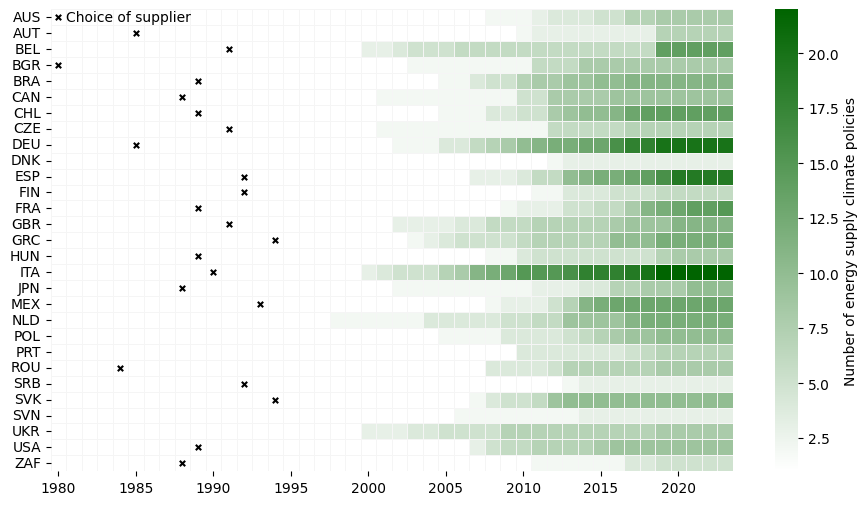

In [10]:
# choice of supplier
pivot_reform_choice_matched = pivot_reform_choice.loc[pivot_coal_phaseout.index,1990:]
pivot_reform_unbundle_matched = pivot_reform_unbundle.loc[pivot_coal_phaseout.index,1990:]
# policy
country_sort_index = pd.DataFrame(data={"cntry":pivot_coal_phaseout.index,
                                        "plot_cntry":np.arange(len(pivot_coal_phaseout.index))+0.5})
plot_policy_data = policy_data[policy_data["ISO"].isin(pivot_coal_phaseout.index)]
plot_policy_data = plot_policy_data[plot_policy_data["num_supply_policy"]>0]
plot_policy_data = pd.merge(plot_policy_data,country_sort_index,left_on="ISO",right_on="cntry")
plot_policy_data["Year"] = plot_policy_data["Year"].astype(int)
pivot_policy_data = plot_policy_data.pivot(index='ISO', columns='Year', values="num_supply_policy")

# x ticks
xticks = pivot_coal_phaseout.columns
keptticks = xticks[::int(len(xticks)/6)]
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/6)] = keptticks

fig, axes = plt.subplots(figsize=(11,6))
cmap0 = LinearSegmentedColormap.from_list('', ['white', 'darkgreen'])
sns.heatmap(pivot_policy_data,linewidths=0.5, linecolor='whitesmoke',cmap=cmap0,
            cbar_kws={'label': 'Number of energy supply climate policies'})
plt.xticks(np.arange(9)*5 + 0.5,rotation=0)
axes.scatter(*np.argwhere(pivot_reform_choice_matched.T == 1).T+0.5,  marker="x", color="black", s=15)
#axes.scatter(*np.argwhere(pivot_reform_unbundle_matched.T == 1).T+0.5,  marker="d", color="orange", s=15)
axes.text(1,0+0.75,"Choice of supplier")
axes.set_ylabel(None)
axes.set_xlabel(None)
fig.savefig("ExtDataFig4_heatmap_policy.png",dpi=600, bbox_inches='tight')